### Data Scopring function for Items with Irregular Patterns


### Importing packages

In [6]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import altair as alt
import vegafusion as vf
import sklearn
import vega_datasets
from sklearn.pipeline import Pipeline, make_pipeline
import seaborn as sns
from matplotlib.patches import Patch


### Functions related to importing and data preparations

In [7]:
def f_concat(l_input):

    # Initialize.
    dummy = ""
    n_len = len(l_input)

    if n_len == 1:
        return l_input[0]

    # Loop through text elements.
    for i in range(n_len - 1):
        dummy = dummy + l_input[i] + ", "

    # Append last element.
    dummy = dummy + "and " + l_input[n_len - 1]

    # Return result.
    return dummy

In [8]:
def f_describe(df_input, n_top=10):

    print("First " + str(n_top) + " rows in de data:")
    display(df_input.head(n_top))

    df_numeric = df_input.select_dtypes(
        include=[
            "uint8",
            "uint16",
            "uint32",
            "uint64",
            "int8",
            "int16",
            "int32",
            "int64",
            "float16",
            "float32",
            "float64",
        ]
    )

    if len(df_numeric.columns):
        print("Numerical data:")
        display(df_numeric.describe())

    df_textual = df_input.select_dtypes(include=["category", "object", "bool"])

    if len(df_textual.columns):
        print("Textual data:")
        display(df_textual.describe())

    v_na = [
        col
        + " ("
        + str(df[col].isna().sum())
        + ", "
        + str(round(100 * df[col].isna().sum() / df.shape[0], 1))
        + "%)"
        for col in df.columns
        if df[col].isna().sum() > 0
    ]

    if len(v_na) > 0:
        print("Features and their number of missing values:")
        display(f_concat(v_na))

In [9]:
def standardize_column_names(s):
    return s.replace(" ", "")


def optimize_memory(df):
    # Change: Objects to Categorical.                                               #WHEN needed to transform Objects to Categorical?
    # object_cols = df.select_dtypes(include="object").columns
    # if not object_cols.empty:
    #     print("Change: Objects to Categorical")
    #     df[object_cols] = df[object_cols].astype("category")

    # Change: Convert integers to smallest unsigned integer and floats to smallest.
    for old, new in [("integer", "unsigned"), ("float", "float")]:
        print("Change: " + old + " --> " + new)
        for col in df.select_dtypes(include=old).columns:
            df[col] = pd.to_numeric(df[col], downcast=new)

    return df


def month_year_to_int(df, i):
    # Change: Month and Year to integer
    if i == 0:
        print("Change: Month and Year to integer")
        df = df.astype({"month": int, "year": int})

    return df

In [10]:
# Convert datasets to time series
def transform_date_to_datetime(df, i):
    if i == 0:
        print("Change: Transformed 'year', 'month', 'day' columns to Datetime feature")
        df["date"] = pd.to_datetime(df[["year", "month", "day"]], unit="us")

        print(
            "Change: Dropped 'year', 'month', 'day' columns and transformed to Datetime64[us] feature"
        )
        df.drop(columns=["day", "month", "year"], inplace=True)

    else:
        if "date" in df.columns:
            print("Change: Transformed 'date' column to Datetime Dtype")
            df["date"] = pd.to_datetime(df["date"]).dt.tz_localize(None)

    return df

In [11]:
def f_get_data(i=0):

    # Define path.
    c_path = "/Users/Georgi/Documents/EAISI/EASI_4B_Supermarket/Group4B/data/raw/"
    # Identify file.
    v_file = (
        "history-per-year",  # 0
        "history_aggregated",  # 1
        "holidays_events",  # 2
        "items",  # 3
        "oil",  # 4
        "stores",  # 5
        "transactions",
    )  # 6

    # Load data.
    df = (
        pd.read_parquet(c_path + v_file[i] + ".parquet")
        .rename(columns=standardize_column_names)
        .pipe(optimize_memory)
        .pipe(month_year_to_int, i)
        .pipe(transform_date_to_datetime, i)
    )

    # Return data.
    return df

### Importing data: Here I import the sales and items data. 

In [12]:
df_sales= f_get_data(0)
df_items =f_get_data(3)

Change: integer --> unsigned
Change: float --> float
Change: Month and Year to integer
Change: Transformed 'year', 'month', 'day' columns to Datetime feature
Change: Dropped 'year', 'month', 'day' columns and transformed to Datetime64[us] feature
Change: integer --> unsigned
Change: float --> float


3.1.4. Function List - Returns a list of all items the belong to families with demand pattern of poor data quality: 'BEVERAGES', 'PRODUCE', 'CELEBRATION', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II','HOME CARE','LADIESWARE','PETS SUPPLIES','PLAYERS AND ELECTRONICS','SCHOOL AND OFFICE SUPPLIES'

In [13]:
def items_exclude_family(df_items, families=['BEVERAGES', 'PRODUCE', 'CELEBRATION', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II','HOME CARE','LADIESWARE','PETS SUPPLIES','PLAYERS AND ELECTRONICS','SCHOOL AND OFFICE SUPPLIES']):
    

    # Get the list of item numbers that belong to the specified families
    list_items_in_families = df_items[df_items["family"].isin(families)]["item_nbr"].tolist()

    return list_items_in_families


3.1.5. Function Drop Items on List - Excludes items sales data with from the list  "list_items_in_families" 

In [14]:
def df_sales_cleaned_items(df_sales, list_items_in_families):
 
    # Drop observations from df_sales where item_nbr is in list_items_in_families
    df_sales_cleaned = df_sales[~df_sales["item_nbr"].isin(list_items_in_families)]

    return df_sales_cleaned

3.1.5A Call the function df_sales_cleaned_items and items_esxcluse_items to reduce the dataset

In [15]:

list_items_to_exclude = items_exclude_family(df_items)  # Step 1: Get items to exclude
cleaned_df_sales = df_sales_cleaned_items(df_sales, list_items_to_exclude)  # Step 2: Clean df_sales



Check the results: before and after 

In [16]:
# Get the length of df_sales before and after cleaning
total_observations_len_prior = len(df_sales)
total_observations_len_post = len(cleaned_df_sales)
rows_removed = total_observations_len_prior - total_observations_len_post

# Print the results in a single line with formatted output
print(f"Total observations before cleaning: {total_observations_len_prior}, after cleaning: {total_observations_len_post}, rows removed: {rows_removed}")


Total observations before cleaning: 125497040, after cleaning: 96180971, rows removed: 29316069


Visualize the changes

/Users/Georgi/Documents/Group4B/venv_case_project/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


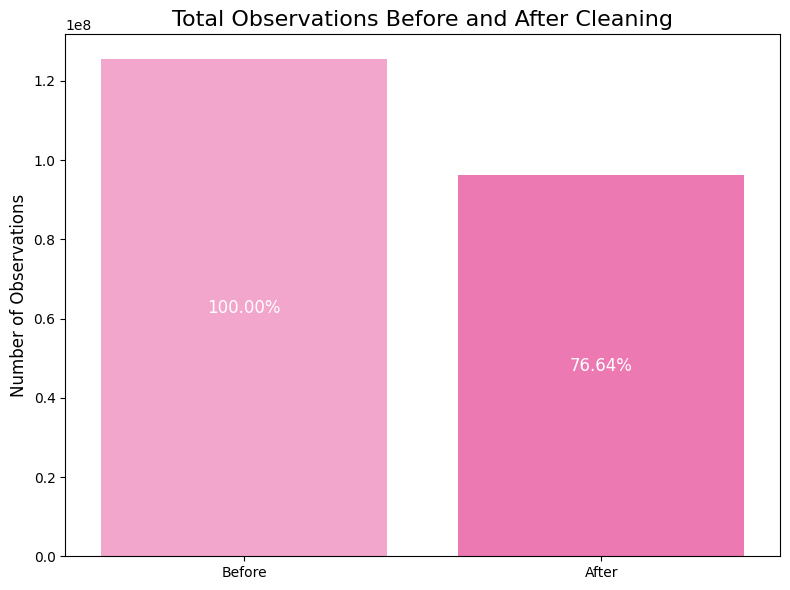

In [17]:
#Source: ChatGPT
# Step 1: Calculate the total number of observations
total_observations_len_prior = len(df_sales)
total_observations_len_post = len(cleaned_df_sales)
rows_removed = total_observations_len_prior - total_observations_len_post

# Step 2: Calculate percentages
percent_remaining = (total_observations_len_post / total_observations_len_prior) * 100
percent_removed = (rows_removed / total_observations_len_prior) * 100

# Step 3: Prepare data for visualization
data = {
    'Group': ['Before', 'After'],
    'Observations': [total_observations_len_prior, total_observations_len_post],
    'Percentage': [100, percent_remaining]
}

# Step 4: Create a bar plot with a "girly" color palette (pinks and purples)
plt.figure(figsize=(8, 6))
bars = sns.barplot(x='Group', y='Observations', data=data, palette=['#ff99cc', '#ff66b2'])  # Soft pink shades

# Step 5: Add the percentages inside the bars
for i, percentage in enumerate(data['Percentage']):
    bars.text(i, data['Observations'][i] / 2,  # Positioning in the middle of the bar
              f'{percentage:.2f}%', ha='center', va='center', fontsize=12, color='white')

# Step 6: Customize the plot
plt.title('Total Observations Before and After Cleaning', fontsize=16)
plt.ylabel('Number of Observations', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()



